# Notebook - Word2Vec

Este notebook descreve as ferramentas utilizadas, os procedimentos realizados, resultados obtidos, comentários e observações a respeito do Trabalho Prático 1 - Word2Vec

## Ferramenta utilizada
Para este trabalho prático, a biblioteca gensim  foi escolhida para implementações das funções de pré-processamento e o treinamento do modelo, na linguagem de programção Python 3. Para a exibição dos gráficos, foi utilizada a biblioteca matlib.

## Etapa 1 - Pré-processamento

O pré-processamento é um procedimento comum antes de treinar modelos de linguagems naturais. Geralmente a entrada textual, ou em outras palavras, o corpus (neste trabalho o text8), possui muitas informações que nem sempre são relevantes. Desta forma, para resaltar as informaçoes que são de fato relevantes, as seguintes funções:
- Remoção das stopwords
- Remoção de sequências de espaços em brancos
- Remoção das pontuações
- Remoção de caracteres númericos
- Remoção das palavras de tamanho 2 ou menor.

In [1]:
import gzip
import gensim
import os
from gensim import corpora
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
from gensim.parsing.preprocessing import remove_stopwords,strip_multiple_whitespaces,strip_punctuation,strip_numeric,strip_short

class pre_process:
    def __iter__(self):
        abspath = os.path.dirname(os.path.abspath(__file__))
        input_file = os.path.join(abspath, "text8.gz")
        # This method reads the input file which is in gzip format
        with gzip.open(input_file, 'rb') as f:
            for i, line in enumerate(f):
                line = remove_stopwords(line)
                line = strip_multiple_whitespaces(line)
                line = strip_punctuation(line)
                line = strip_numeric(line)
                yield gensim.utils.simple_preprocess(line,min_len=3)

## Etapa 2 - Treinamento e parâmetros

Com a classe de pré-processamento pronta, utilizamos ela para extrair a lista de tokens relevantes do corpus, gerando o vocabulário. Além da lista de tokens, os seguintes parâmetros são exigidos:
    - vector size: Número de dimensóes N do espaço N dimensional que o gensim utliza para mapear as palavras.
    - window: Máxima distância entre a palavra (token) atual e a palavra prevista.
    - min_count: Toda palavra que tiver um número total de frequência menor do que o min_count é ignorada pelo modelo.
    - max_final_vocab: Limita o tamanho do vocabulário.
    - negative_sampling: Especifica quantas "noise words" devem ser estabelecidas.
    - sg: Define se o modelo a ser treinado vai ser CBOW ou Skip-Gram (0 = CBOW, 1 = Skip-Gram)
Diversos valores de parametrôs foram testados, window (4,5,9,10), size (100,150,200,250), min_count (1,3,5,7), negative_sampling (5,15,20) max_final_vocab (0,5000). Dentre os testes realizados, os parametrôs mais convincentes foram (size 100,150,200), min_count(1), window(4), negative_sampling (15) max_final_vocab(5000). A maior diferença de acurácia notada ao modificar um parâmetro entre os dois modelos foi no tamanho dos vetores, enquanto que o CBOW apresentou melhores resultados em vetores menores, no Skip-Gram ocorreu o oposto.

In [ ]:
def treinoCBOW ():
    list_tokens = list(pre_process())
    model = gensim.models.Word2Vec(
        list_tokens,
        size=120,
        window=4,
        min_count=1,
        max_final_vocab =5000,
        negative=15,
        sg = 0)
    model.train(list_tokens, total_examples=len(list_tokens), epochs=10)
    model.wv.save("vectors\word2vecCBOW.wordvectors")

In [ ]:
def treinoSkipGram ():
    list_tokens = list(pre_process())
    model = gensim.models.Word2Vec(
        list_tokens,
        size=200,
        max_final_vocab =5000,
        window=4,
        min_count=1,
        negative=15,
        sg = 1)
    model.train(list_tokens, total_examples=len(list_tokens), epochs=10)
    model.wv.save("vectors\word2vecSG.wordvectors")

## Etapa 3 - Avaliando o modelo

Para avaliação do modelo, uma estratégia comumente utilizada nos trabalhos é pelo teste de analogias. As analogias são separadas por seções e descritas como uma tupla de 4 palavras, geralmente em um arquivo texto chamado "question-words.txt". A função abaixo recebe um modelo treinado e realiza as analogias, relatando a quantidade de acertos e erros obtidos em cada analogia.

In [2]:
def w2v_model_accuracy(model):
    accuracy = model.accuracy(datapath("questions-words.txt"))

    sum_corr = len(accuracy[-1]['correct'])
    sum_incorr = len(accuracy[-1]['incorrect'])
    total = sum_corr + sum_incorr
    percent = lambda a: a / total * 100

    print('Total sentences: {}, Correct: {:.2f}%, Incorrect: {:.2f}%'.format(total, percent(sum_corr),
                                                                             percent(sum_incorr)))

Para o modelo CBOW, os resultados obtidos para as analogias foram:

E para o Skip-Gram:

Foi observado que os modelos tiveram muitos erros nas analogias em geral, obtendo apenas alguns acertos nas seções de nacionalidade-adjetivo.

Mas como os modelos realizaram tarefas não supervisionadas, não é recomendado avaliar um modelo apenas com analogias. Desta maneira, algumas questões foram testadas manualmente:

In [ ]:
print(model.similarity('woman', 'man'))


Para ambos os modelos, a similiriadade entre homem e mulheres foram maiores do que 99%. Vamos seguir com os testes:

In [ ]:
print(model.wv.most_similar(positive=["crown"]))

Nesse teste, foi perguntado ao modelo CBOW quais são as palavras mais similiares a "crown" (coroa em português) e uma palavra interessante foi destacada como a segunda mais similiar: "empire" (império em português), o que de fato faz sentido e nos indica que o modelo não está tão errado assim. Seguiremos agora com mais um teste no modelo CBOW:

In [ ]:
print(model.wv.most_similar(positive=["king"]))

Assim como no caso da palavra coroa, ao testarmos as palavras mais similiares com "king" (rei), percebemos a presença da palavra "man" (homem) com mais de 99% de similiariadade, o que, mais uma vez, nos indica que o modelo está indo pelo caminho certo.
Como apenas obter resultados das palavras mais similiares e lista de palavras pode não ser muito intuitivo para analisar um modelo, vamos então visualizar os vetores de palavras no espaço dimensional.

t-SNE Visualizations:

t-SNE é um algoritmo não linear de redução de dimensionalidade que tenta representar dados de altas dimensões e as relações entre os vetores em um espaço de baixa dimensionalidade. Através do uso dessa técnica, podemos visualizar os vetores que treinamos e obtemos nas perguntas de similiaridades.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def display_closestwords_tsnescatterplot(model, word, size):
    arr = np.empty((0, size), dtype='f')
    word_labels = [word]
    close_words = model.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min() + 0.00120, x_coords.max() + 0.00120)
    plt.ylim(y_coords.min() + 0.00120, y_coords.max() + 0.00120)
    plt.show()
model = KeyedVectors.load("vectors\word2vecCBOW.wordvectors", mmap='r')
display_closestwords_tsnescatterplot(model, 'king', 120)

Com o trecho de código acima, criamos a função de plotagem para a visualização dos vetores e a chamamos para exibir os resultados obtidos na pergunta, no modelo CBOW, que fizemos anteriormente: - "Quais são as palavras mais próximas a king?"
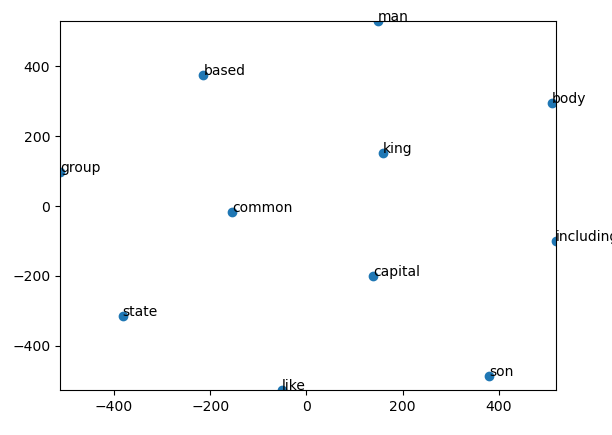
E os resultados no modelo Skip-Gram:
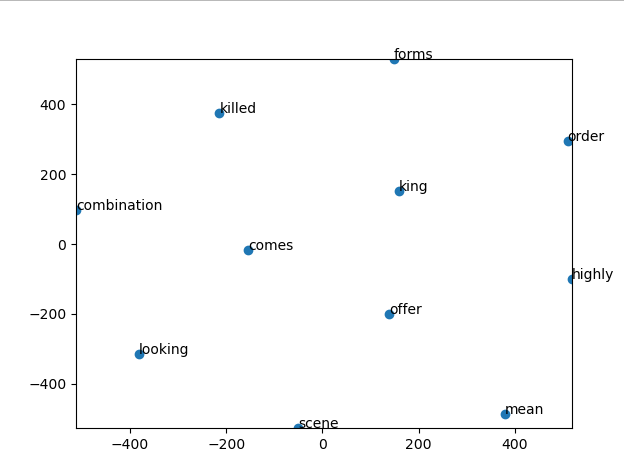
(Será que algum rei foi morto?)
De maneira similiar, podemos reproduzir novamente a pergunta: - "Quais são as palavras mais próximas a crown?"
No modelo CBOW:
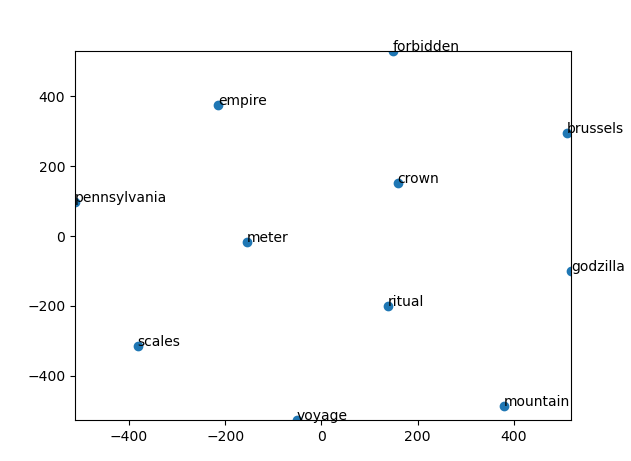
E no Skip-Gram:
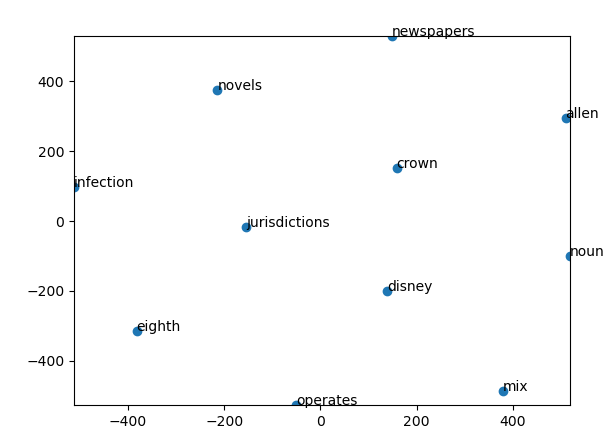


## Conclusões e comentários

Após diversos testes realizados em ambos os modelos eu pude concluir que, por mais que a quantidade de acertos nas analogias do arquivo question-words.txt sejam pequenas, isto não quer dizer que o modelo treinado é inutíl e totalmente errôneo. Pelo contrário, mesmo com os resultados obtidos nas analogias serem ruins, após visualizar com mais calmas nas plotagens gráficas, foi possível perceber que as palavras similiares possuem um sentido. Além disso, também percebi a importância do pré-processamento e o quanto isto ajudou no treinamento do modelo.

Leonardo Santos Miranda